## Card Transaction Fraud Detection

Simulate a dataset of card transactions including geo location to utilize machine learning to detect fraud

Source:
Borgne, et al., (2022). Reproducible Machine Learning for Fraud Detection - Practical Handbook. Universite Libre de Bruxelles. 
https://github.com/Fraud-Detection-Handbook/fraud-detection-handbook/tree/main

In [6]:
import os

import numpy as np
import pandas as pd

import datetime
import time

import random

# For plotting
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
random.seed(2024)

### Functions needed for Simulation

Customer profiles include customer IDs, their x and y coordinates (location), the mean and std amounts of the customers and mean transactions per day.

Terminal profiles include ID and their x and y coordinates.

Transactions are generated on a daily basis, with random seed for each customer ID, and only on terminals in a specific radius of their location

Generate dataset utilizes the above functions to generate a large dataset.

In [7]:
#Customer Profiles

def generate_customer_profiles_table(n_customers, random_state=0):
    
    np.random.seed(random_state)
        
    customer_id_properties=[]
    
    # Generate customer properties from random distributions 
    for customer_id in range(n_customers):
        
        x_customer_id = np.random.uniform(0,100)
        y_customer_id = np.random.uniform(0,100)
        
        mean_amount = np.random.uniform(5,100) # Arbitrary (but sensible) value 
        std_amount = mean_amount/2 # Arbitrary (but sensible) value
        
        mean_nb_tx_per_day = np.random.uniform(0,4) # Arbitrary (but sensible) value 
        
        customer_id_properties.append([customer_id,
                                      x_customer_id, y_customer_id,
                                      mean_amount, std_amount,
                                      mean_nb_tx_per_day])
        
    customer_profiles_table = pd.DataFrame(customer_id_properties, columns=['CUSTOMER_ID',
                                                                      'x_customer_id', 'y_customer_id',
                                                                      'mean_amount', 'std_amount',
                                                                      'mean_nb_tx_per_day'])
    
    return customer_profiles_table

#Terminal Profiles
def generate_terminal_profiles_table(n_terminals, random_state=0):
    
    np.random.seed(random_state)
        
    terminal_id_properties=[]
    
    # Generate terminal properties from random distributions 
    for terminal_id in range(n_terminals):
        
        x_terminal_id = np.random.uniform(0,100)
        y_terminal_id = np.random.uniform(0,100)
        
        terminal_id_properties.append([terminal_id,
                                      x_terminal_id, y_terminal_id])
                                       
    terminal_profiles_table = pd.DataFrame(terminal_id_properties, columns=['TERMINAL_ID',
                                                                      'x_terminal_id', 'y_terminal_id'])
    
    return terminal_profiles_table

#Get list of Terminals within Radius
def get_list_terminals_within_radius(customer_profile, x_y_terminals, r):
    
    # Use numpy arrays in the following to speed up computations
    
    # Location (x,y) of customer as numpy array
    x_y_customer = customer_profile[['x_customer_id','y_customer_id']].values.astype(float)
    
    # Squared difference in coordinates between customer and terminal locations
    squared_diff_x_y = np.square(x_y_customer - x_y_terminals)
    
    # Sum along rows and compute suared root to get distance
    dist_x_y = np.sqrt(np.sum(squared_diff_x_y, axis=1))
    
    # Get the indices of terminals which are at a distance less than r
    available_terminals = list(np.where(dist_x_y<r)[0])
    
    # Return the list of terminal IDs
    return available_terminals

#Generate Transactions
def generate_transactions_table(customer_profile, start_date = "2018-04-01", nb_days = 10):
    
    customer_transactions = []
    
    random.seed(int(customer_profile.CUSTOMER_ID))
    np.random.seed(int(customer_profile.CUSTOMER_ID))
    
    # For all days
    for day in range(nb_days):
        
        # Random number of transactions for that day 
        nb_tx = np.random.poisson(customer_profile.mean_nb_tx_per_day)
        
        # If nb_tx positive, let us generate transactions
        if nb_tx>0:
            
            for tx in range(nb_tx):
                
                # Time of transaction: Around noon, std 20000 seconds. This choice aims at simulating the fact that 
                # most transactions occur during the day.
                time_tx = int(np.random.normal(86400/2, 20000))
                
                # If transaction time between 0 and 86400, let us keep it, otherwise, let us discard it
                if (time_tx>0) and (time_tx<86400):
                    
                    # Amount is drawn from a normal distribution  
                    amount = np.random.normal(customer_profile.mean_amount, customer_profile.std_amount)
                    
                    # If amount negative, draw from a uniform distribution
                    if amount<0:
                        amount = np.random.uniform(0,customer_profile.mean_amount*2)
                    
                    amount=np.round(amount,decimals=2)
                    
                    if len(customer_profile.available_terminals)>0:
                        
                        terminal_id = random.choice(customer_profile.available_terminals)
                    
                        customer_transactions.append([time_tx+day*86400, day,
                                                      customer_profile.CUSTOMER_ID, 
                                                      terminal_id, amount])
            
    customer_transactions = pd.DataFrame(customer_transactions, columns=['TX_TIME_SECONDS', 'TX_TIME_DAYS', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT'])
    
    if len(customer_transactions)>0:
        customer_transactions['TX_DATETIME'] = pd.to_datetime(customer_transactions["TX_TIME_SECONDS"], unit='s', origin=start_date)
        customer_transactions=customer_transactions[['TX_DATETIME','CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT','TX_TIME_SECONDS', 'TX_TIME_DAYS']]
    
    return customer_transactions 

#Generate Dataset
def generate_dataset(n_customers = 10000, n_terminals = 1000000, nb_days=90, start_date="2018-04-01", r=5):
    
    start_time=time.time()
    customer_profiles_table = generate_customer_profiles_table(n_customers, random_state = 0)
    print("Time to generate customer profiles table: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    terminal_profiles_table = generate_terminal_profiles_table(n_terminals, random_state = 1)
    print("Time to generate terminal profiles table: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    x_y_terminals = terminal_profiles_table[['x_terminal_id','y_terminal_id']].values.astype(float)
    customer_profiles_table['available_terminals'] = customer_profiles_table.apply(lambda x : get_list_terminals_within_radius(x, x_y_terminals=x_y_terminals, r=r), axis=1)
    # With Pandarallel
    #customer_profiles_table['available_terminals'] = customer_profiles_table.parallel_apply(lambda x : get_list_closest_terminals(x, x_y_terminals=x_y_terminals, r=r), axis=1)
    customer_profiles_table['nb_terminals']=customer_profiles_table.available_terminals.apply(len)
    print("Time to associate terminals to customers: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=nb_days)).reset_index(drop=True)
    # With Pandarallel
    #transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').parallel_apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=nb_days)).reset_index(drop=True)
    print("Time to generate transactions: {0:.2}s".format(time.time()-start_time))
    
    # Sort transactions chronologically
    transactions_df=transactions_df.sort_values('TX_DATETIME')
    # Reset indices, starting from 0
    transactions_df.reset_index(inplace=True,drop=True)
    transactions_df.reset_index(inplace=True)
    # TRANSACTION_ID are the dataframe indices, starting from 0
    transactions_df.rename(columns = {'index':'TRANSACTION_ID'}, inplace = True)
    
    return (customer_profiles_table, terminal_profiles_table, transactions_df)

### Run the Simulation
In this case, 10,000 customers, 20,000 terminals for 200 days and a radius of 5.

In [8]:
(customer_profiles_table, terminal_profiles_table, transactions_df)=\
    generate_dataset(n_customers = 10000, 
                     n_terminals = 20000, 
                     nb_days=200, 
                     start_date="2023-06-30", 
                     r=5)


Time to generate customer profiles table: 0.079s
Time to generate terminal profiles table: 0.048s
Time to associate terminals to customers: 1.2s


/var/folders/x5/tlnfn1690c57g1_tz3cvycb00000gn/T/ipykernel_1329/2357976830.py:144: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=nb_days)).reset_index(drop=True)
/var/folders/x5/tlnfn1690c57g1_tz3cvycb00000gn/T/ipykernel_1329/2357976830.py:144: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  transactions_df=customer_profiles_tab

Time to generate transactions: 6.6e+01s


In [9]:
transactions_df.shape

(3878497, 7)

Sim created 3,878,497 transactions

Plotting distribution below:

In [12]:
%%capture

distribution_amount_times_fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_AMOUNT'].sample(n=10000).values
time_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_TIME_SECONDS'].sample(n=10000).values

sns.distplot(amount_val, ax=ax[0], color='r', hist = True, kde = False)
ax[0].set_title('Distribution of transaction amounts', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])
ax[0].set(xlabel = "Amount", ylabel="Number of transactions")

# We divide the time variables by 86400 to transform seconds to days in the plot
sns.distplot(time_val/86400, ax=ax[1], color='b', bins = 100, hist = True, kde = False)
ax[1].set_title('Distribution of transaction times', fontsize=14)
ax[1].set_xlim([min(time_val/86400), max(time_val/86400)])
ax[1].set_xticks(range(10))
ax[1].set(xlabel = "Time (days)", ylabel="Number of transactions")

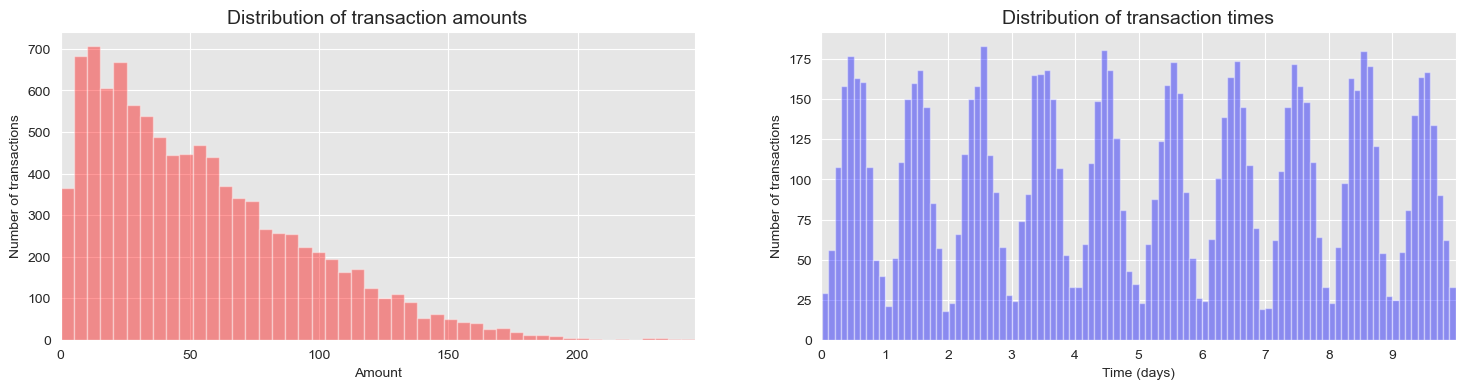

In [13]:
distribution_amount_times_fig

### Adding Fraud Transactions to the Dataset

* Scenario 1: Any transaction whose amount is more than 220 is a fraud. This scenario is not inspired by a real-world scenario. Rather, it will provide an obvious fraud pattern that should be detected by any baseline fraud detector. This will be useful to validate the implementation of a fraud detection technique.

* Scenario 2: Every day, a list of two terminals is drawn at random. All transactions on these terminals in the next 28 days will be marked as fraudulent. This scenario simulates a criminal use of a terminal, through phishing for example. .

* Scenario 3: Every day, a list of 3 customers is drawn at random. In the next 14 days, 1/3 of their transactions have their amounts multiplied by 5 and marked as fraudulent. This scenario simulates a card-not-present fraud where the credentials of a customer have been leaked. The customer continues to make transactions, and transactions of higher values are made by the fraudster who tries to maximize their gains.

* Scenario 4 (Possibly Add): transactions are occuring at two terminals far apart, close in time. Representing fraud via card number theft.

In [14]:
def add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df):
    
    # By default, all transactions are genuine
    transactions_df['TX_FRAUD']=0
    transactions_df['TX_FRAUD_SCENARIO']=0
    
    # Scenario 1
    transactions_df.loc[transactions_df.TX_AMOUNT>220, 'TX_FRAUD']=1
    transactions_df.loc[transactions_df.TX_AMOUNT>220, 'TX_FRAUD_SCENARIO']=1
    nb_frauds_scenario_1=transactions_df.TX_FRAUD.sum()
    print("Number of frauds from scenario 1: "+str(nb_frauds_scenario_1))
    
    # Scenario 2
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        
        compromised_terminals = terminal_profiles_table.TERMINAL_ID.sample(n=2, random_state=day)
        
        compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) & 
                                                    (transactions_df.TX_TIME_DAYS<day+28) & 
                                                    (transactions_df.TERMINAL_ID.isin(compromised_terminals))]
                            
        transactions_df.loc[compromised_transactions.index,'TX_FRAUD']=1
        transactions_df.loc[compromised_transactions.index,'TX_FRAUD_SCENARIO']=2
    
    nb_frauds_scenario_2=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_1
    print("Number of frauds from scenario 2: "+str(nb_frauds_scenario_2))
    
    # Scenario 3
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        
        compromised_customers = customer_profiles_table.CUSTOMER_ID.sample(n=3, random_state=day).values
        
        compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) & 
                                                    (transactions_df.TX_TIME_DAYS<day+14) & 
                                                    (transactions_df.CUSTOMER_ID.isin(compromised_customers))]
        
        nb_compromised_transactions=len(compromised_transactions)
        
        
        random.seed(day)
        index_fauds = random.sample(list(compromised_transactions.index.values),k=int(nb_compromised_transactions/3))
        
        transactions_df.loc[index_fauds,'TX_AMOUNT']=transactions_df.loc[index_fauds,'TX_AMOUNT']*5
        transactions_df.loc[index_fauds,'TX_FRAUD']=1
        transactions_df.loc[index_fauds,'TX_FRAUD_SCENARIO']=3
        
                             
    nb_frauds_scenario_3=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_2-nb_frauds_scenario_1
    print("Number of frauds from scenario 3: "+str(nb_frauds_scenario_3))
    
    return transactions_df 

In [15]:
%time transactions_df = add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df)

Number of frauds from scenario 1: 2113
Number of frauds from scenario 2: 9962
Number of frauds from scenario 3: 5535
CPU times: user 1min 52s, sys: 1.55 s, total: 1min 54s
Wall time: 1min 54s


In [19]:
mean = transactions_df.TX_FRAUD.mean()
sum = transactions_df.TX_FRAUD.sum()

print(mean, '% of transactions are fraudulent')
print(sum, 'of transactions are fraudulent')

transactions_df.head()

0.004540418620924549 % of transactions are fraudulent
17610 of transactions are fraudulent


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:17,6160,6202,31.83,17,0,0,0
1,1,2018-04-01 00:00:31,596,6532,57.16,31,0,0,0
2,2,2018-04-01 00:01:05,9339,10651,28.92,65,0,0,0
3,3,2018-04-01 00:02:10,4961,8673,81.51,130,0,0,0
4,4,2018-04-01 00:02:21,6170,4884,25.17,141,0,0,0


### Save the dataset as parquet file for easy loading into R

Will also be made accessible on GitHub

In [21]:
transactions_df.to_parquet('/Users/Lucas/Documents/CUNY/DATA622/fraud.parquet')